All needed libraries and steps

In [171]:
#!pip3 install plotly==4.14.3
#!pip3 install -U datapane
#!sudo pip3 install matplotlib
#!pip3 install -U scikit-learn scipy matplotlib
#!jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10 --allow-root

import plotly.express as px
from pandas import DataFrame
from datetime import datetime, date, time, timedelta
import pandas as pd
import numpy as np
import datapane as dp
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from itertools import islice
import json

Data Import

In [172]:
#Import LTE network data from JSON file
data = []
with open('LTE.json') as f:
    for line in f:
        data.append(json.loads(line))

        #Convert JSON data from Python dict to DF
LTE_DATA = pd.json_normalize(data)

Preliminary Data Clean

In [173]:
#Drop duplicate data where rows have same timestamp
LTE_DATA = LTE_DATA.drop_duplicates(subset=['timestamp'])

#Set LTE condition
LTE_net = LTE_DATA['net_param.net_type']=='LTE'

#Select only LTE data
LTE_DATA = LTE_DATA[LTE_net]

#Replace all that values at the boudaries with integer values, so that they can be converted into float
LTE_DATA = LTE_DATA.replace(['>=-51','<=-113','<-20','<-19.5','<-140'],['-50','-120','-21','-20','-144'])

#Converto DF into float (only numbers)
LTE_DATA = LTE_DATA.apply(pd.to_numeric, errors='ignore')

#Convert timestamp into datetime
LTE_DATA["timestamp"] = pd.to_datetime(LTE_DATA["timestamp"])

#Print Dtypes for debug
print(LTE_DATA.dtypes)

interface                           object
timestamp                   datetime64[ns]
net_param.net_type                  object
net_param.rsrq                     float64
net_param.rsrp                       int64
net_param.rssi                       int64
net_param.sinr                       int64
net_param.band                       int64
net_param.pci                        int64
uav_param.mode                      object
uav_param.status                    object
uav_param.battery                  float64
uav_param.attitude.pitch           float64
uav_param.attitude.yaw             float64
uav_param.attitude.roll            float64
gps_param.latitude                 float64
gps_param.longitude                float64
gps_param.altitude                 float64
gps_param.groundspeed              float64
gps_param.velocity.vx              float64
gps_param.velocity.vy              float64
gps_param.velocity.vz              float64
gps_param.head                       int64
gps_param.h

Time clustering to separate different flight mission

In [174]:
#Convert timestamp of dataframe to python datetime
LTE_DATA.timestamp = LTE_DATA.timestamp.dt.to_pydatetime()
#LTE_DATA['timestamp'][100:450]

#Define the minimum time difference between flights, in order to identy clusters of data
delta = timedelta(minutes=2)
final = list()
tmp = list()

#First row
tmp.append(LTE_DATA.iloc[0,:])

#First datetime
previous = LTE_DATA.iloc[0,1]

#Scan dataframe looking for clusters and then append them into a list of dataframes
for index, row in islice(LTE_DATA.iterrows(), 1, None):
    dt = row.timestamp
    if dt - previous > delta:
        #if len(tmp) > 2:
        final.append(tmp)
        tmp = list()
    tmp.append(row)
    previous = dt

#Append last cluster to the list of DF
final.append(tmp)

#Remove flight with less than 100 rows
flights = []
for i in range(len(final)):
    #print(len(final[i]))
    if len(final[i])>100:
        flights.append(final[i])

#Print N° of flights
print("Found ", len(flights), " flights")

#Print flight lenght
for i in range(len(flights)):
    print("Flight N°", i+1, "has ", len(flights[i]), " rows of data")

Found  10  flights
Flight N° 1 has  517  rows of data
Flight N° 2 has  867  rows of data
Flight N° 3 has  920  rows of data
Flight N° 4 has  669  rows of data
Flight N° 5 has  635  rows of data
Flight N° 6 has  680  rows of data
Flight N° 7 has  489  rows of data
Flight N° 8 has  392  rows of data
Flight N° 9 has  376  rows of data
Flight N° 10 has  612  rows of data


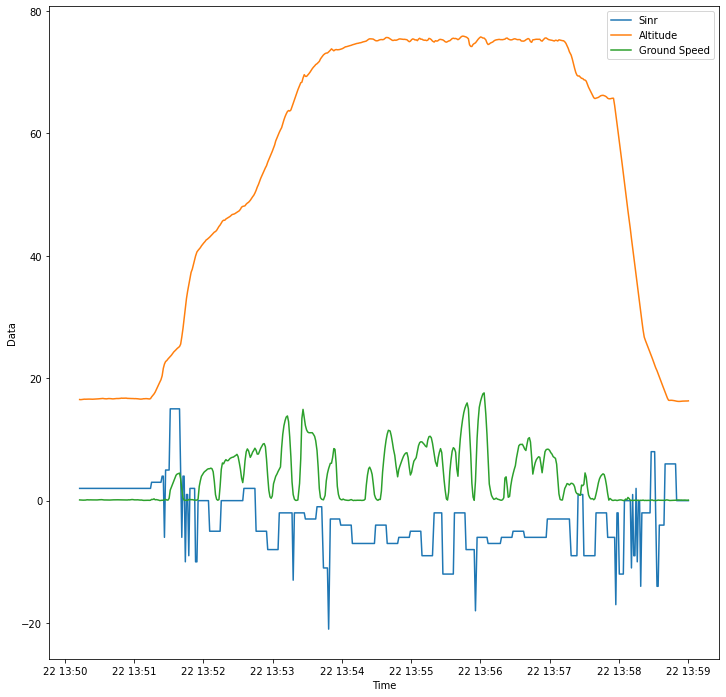

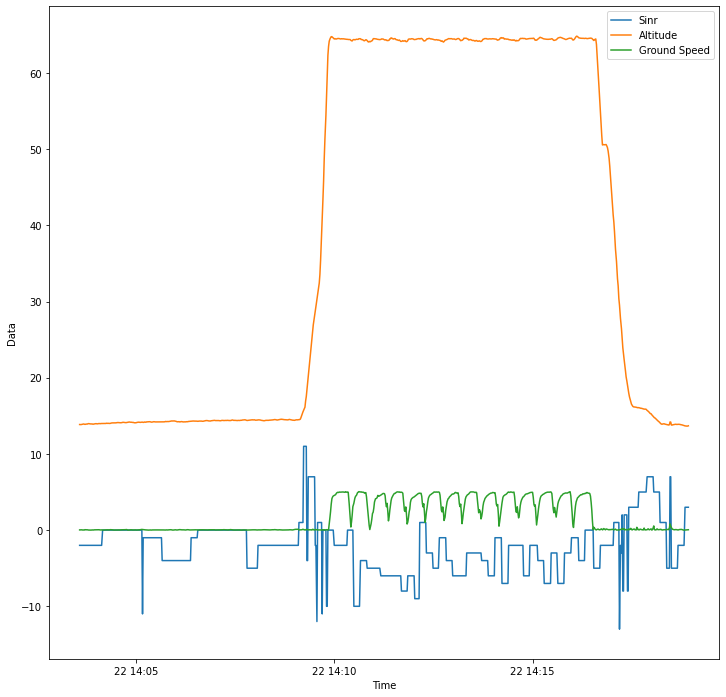

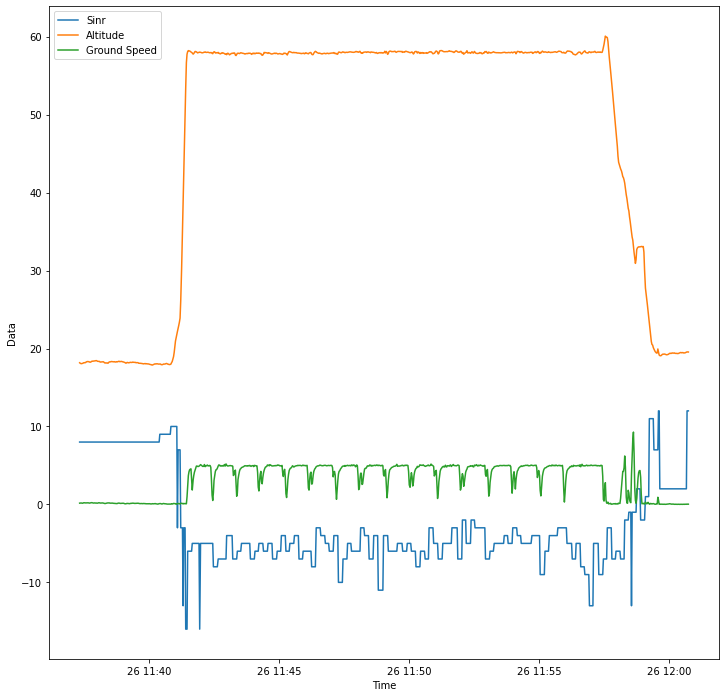

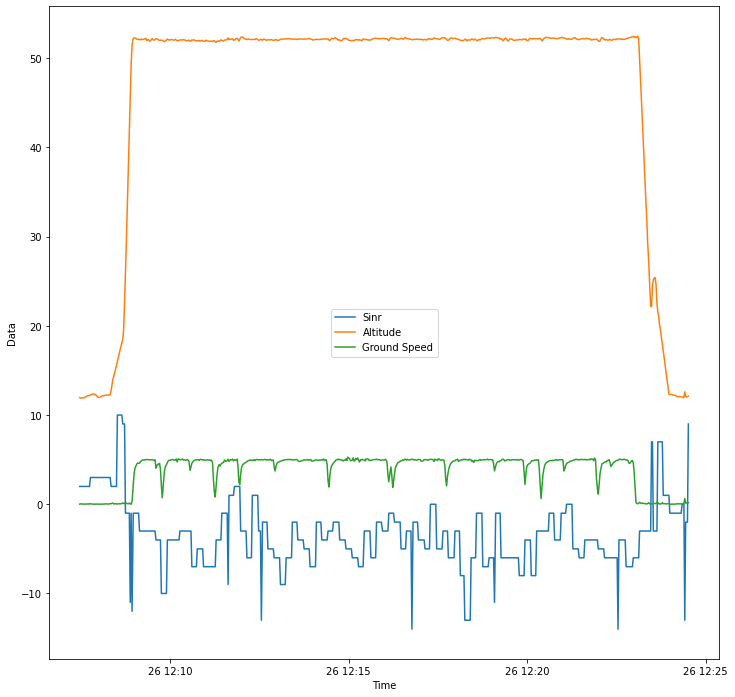

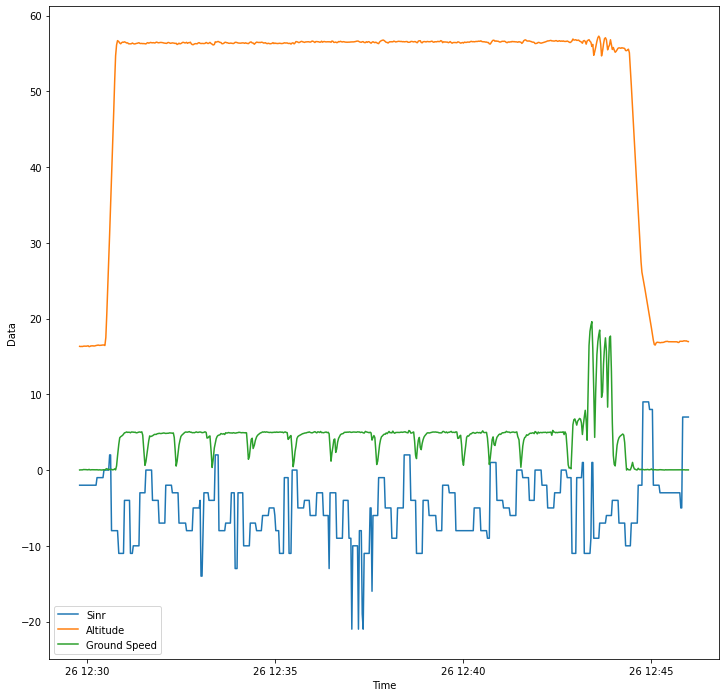

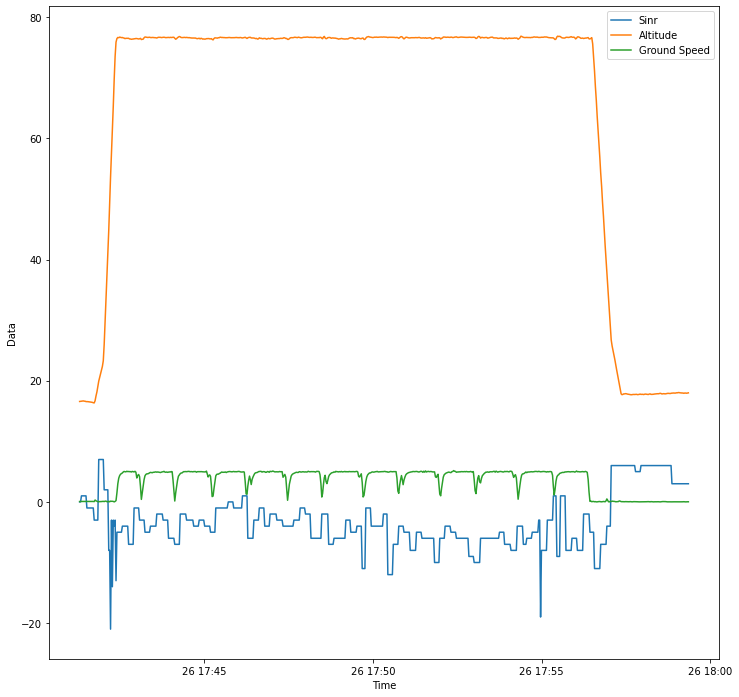

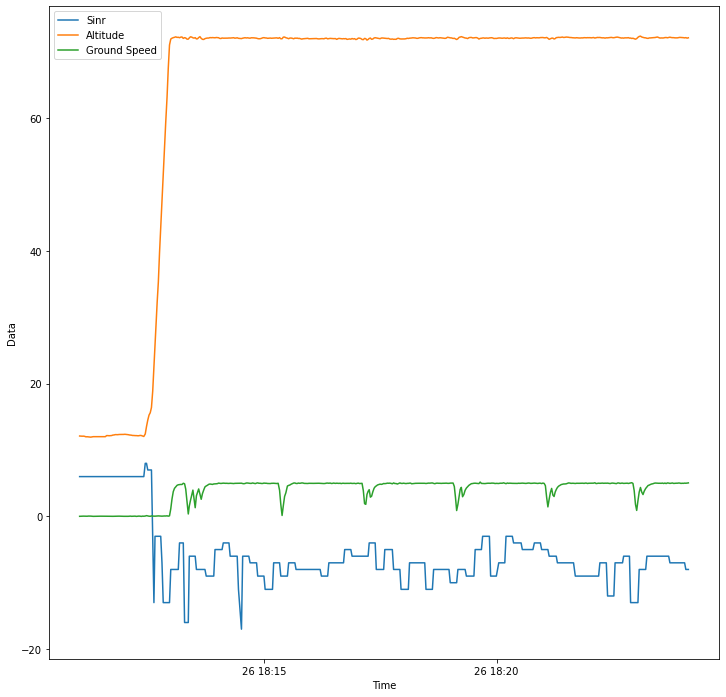

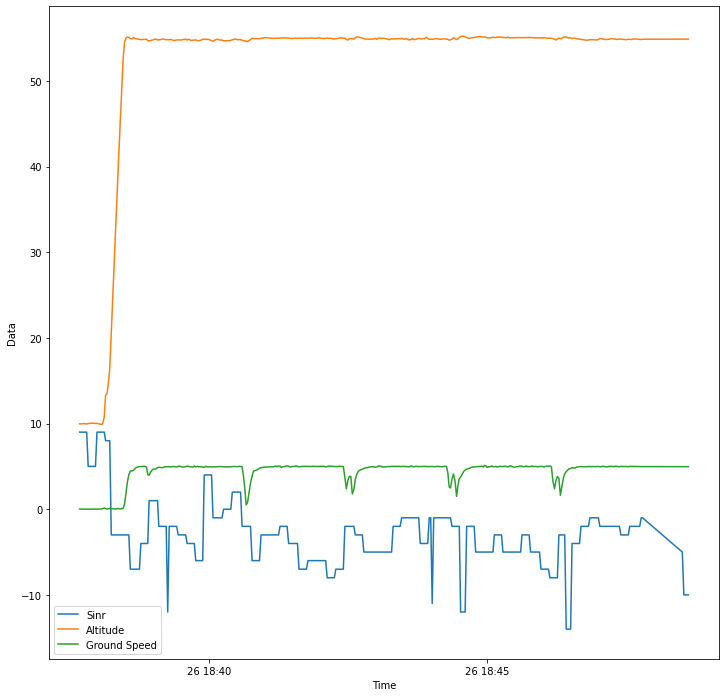

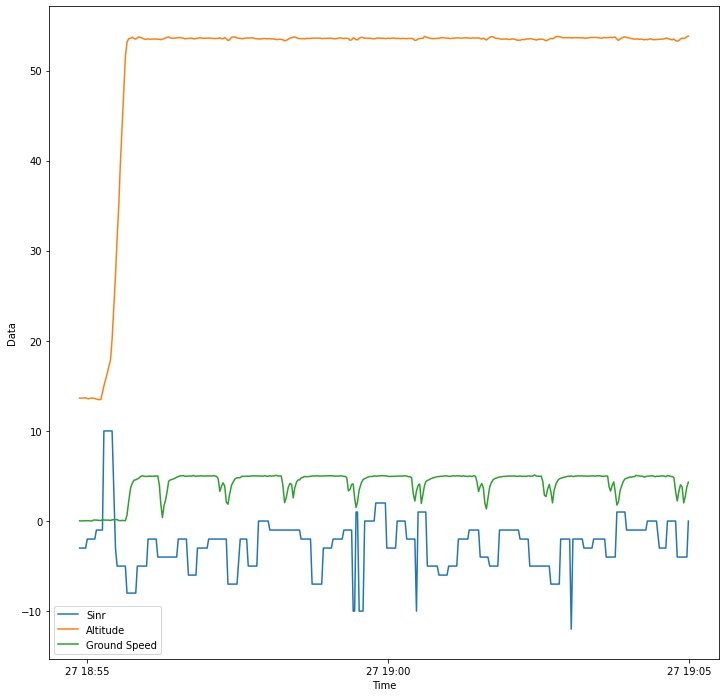

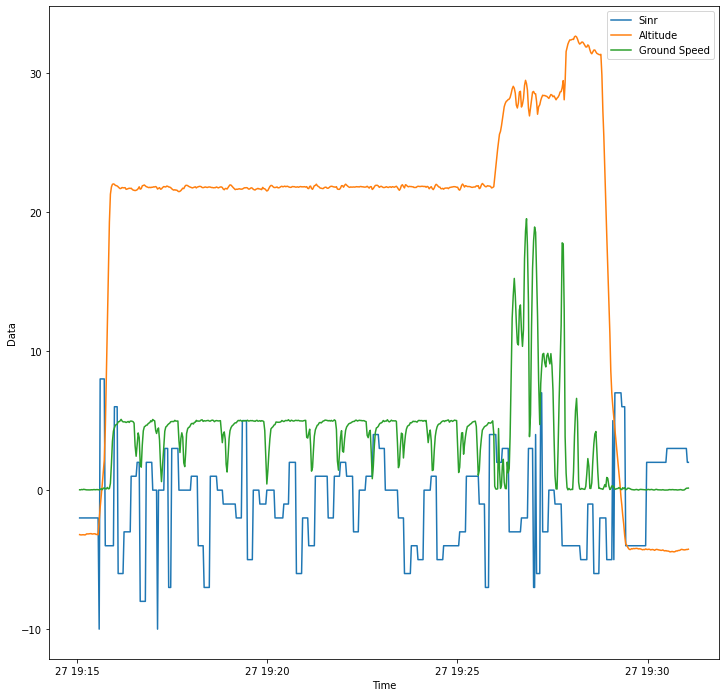

In [175]:
#Print preliminary data plots
for f in range(len(flights)):
    #define figures for plots
    fig = plt.figure(figsize = (12, 12)).add_subplot()
    DF = DataFrame (flights[f])

    #fig.plot(flights[f]['timestamp'], flights[f]['net_param.rssi'])
    fig.plot(DF['timestamp'], DF['net_param.sinr'])
    fig.plot(DF['timestamp'], DF['gps_param.altitude'])
    #fig.plot(LTE_DATA['timestamp'], LTE_DATA['net_param.rsrp'])
    #fig.plot(LTE_DATA['timestamp'], LTE_DATA['net_param.rsrq'])
    fig.plot(DF['timestamp'], DF['gps_param.groundspeed'])

    #add X, and Y labels
    fig.set_xlabel('Time')
    fig.set_ylabel('Data')
    fig.legend(['Sinr','Altitude','Ground Speed'])


Flight N° 1 has  517  rows of data
Flight N° 2 has  867  rows of data
Flight N° 3 has  920  rows of data
Flight N° 4 has  669  rows of data
Flight N° 5 has  635  rows of data
Flight N° 6 has  680  rows of data
Flight N° 7 has  612  rows of data


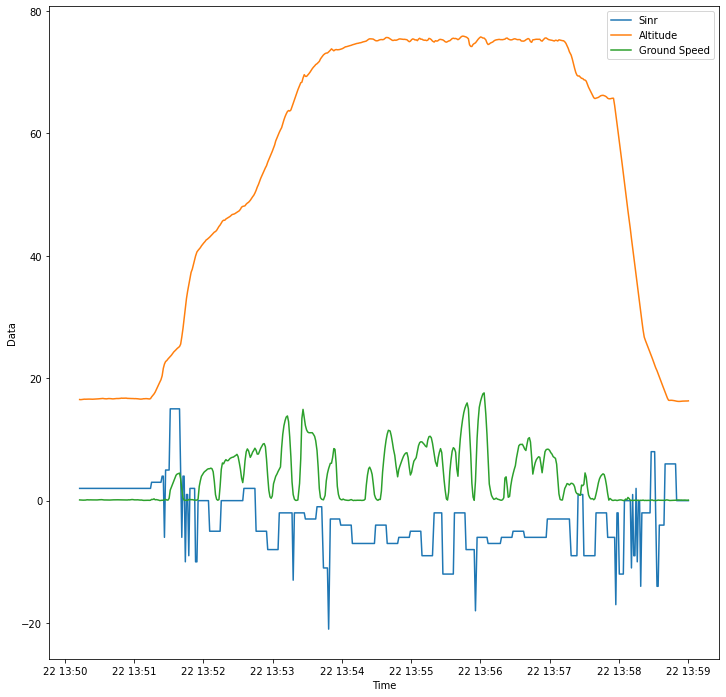

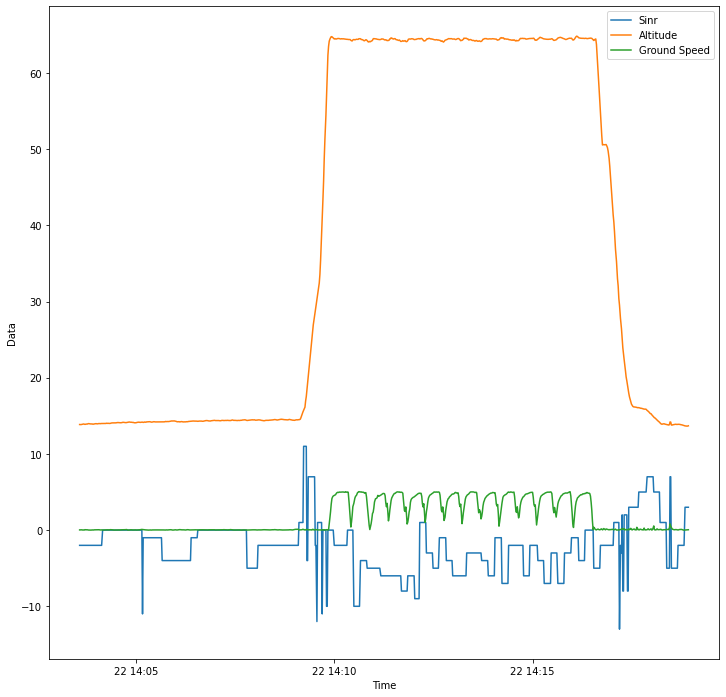

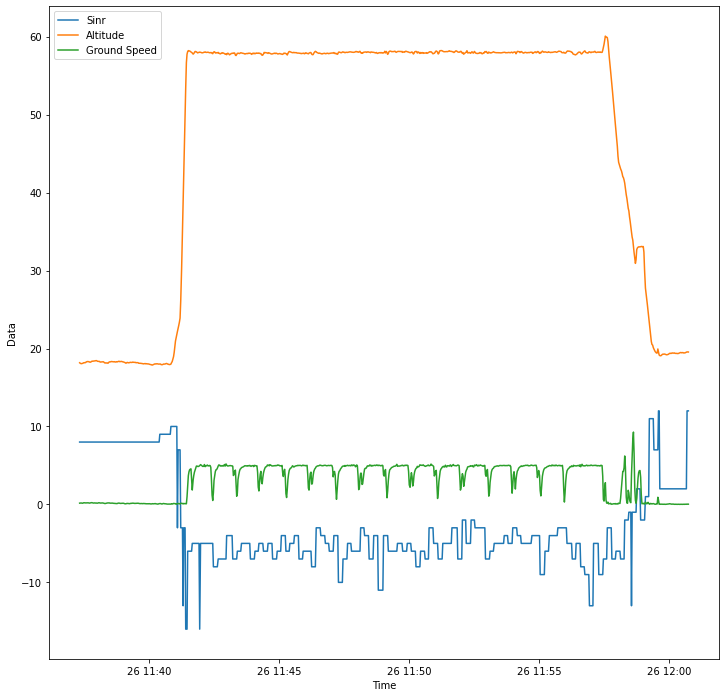

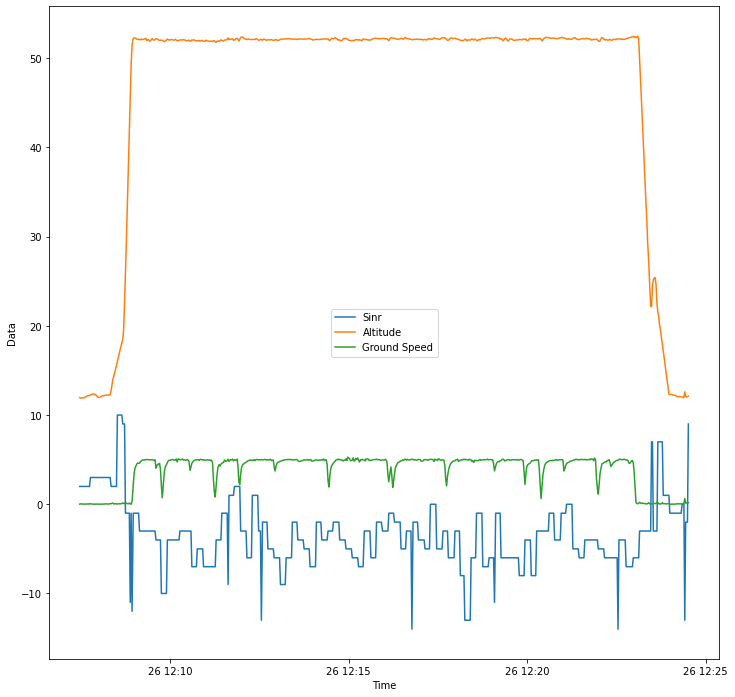

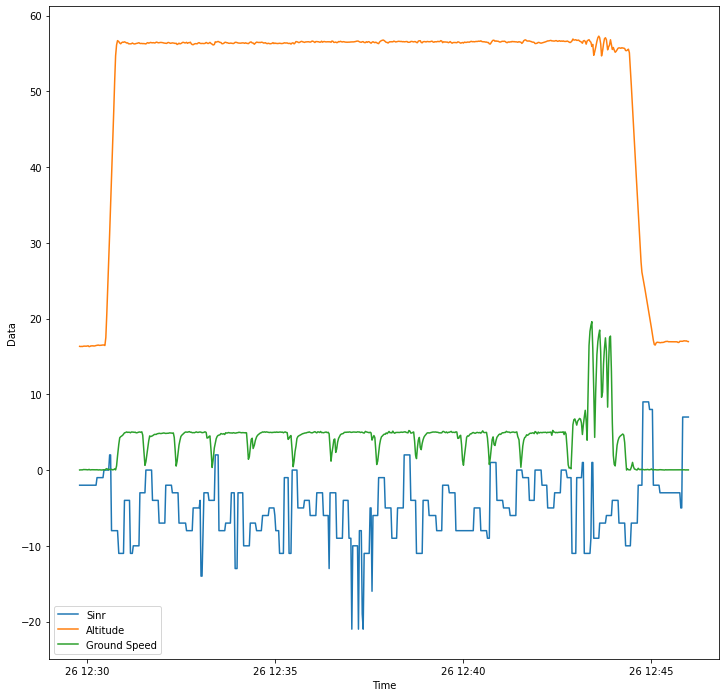

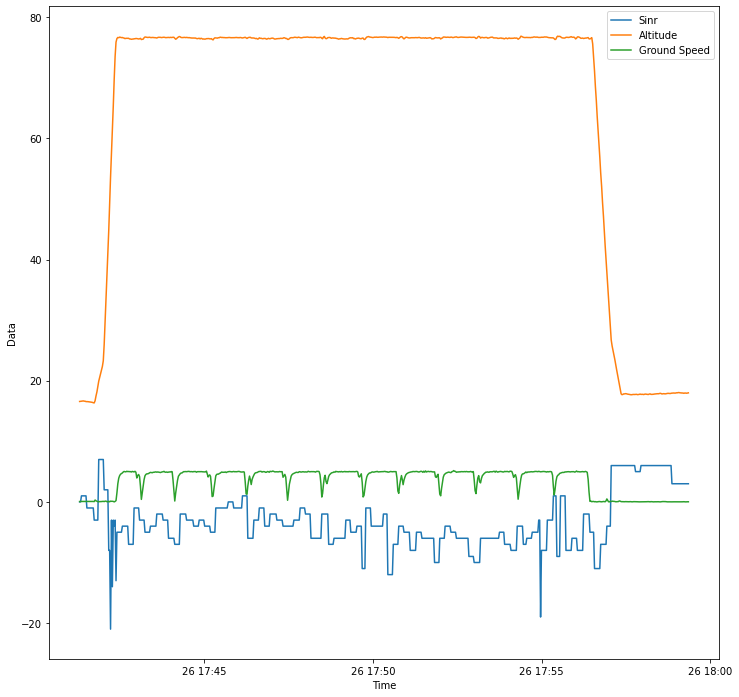

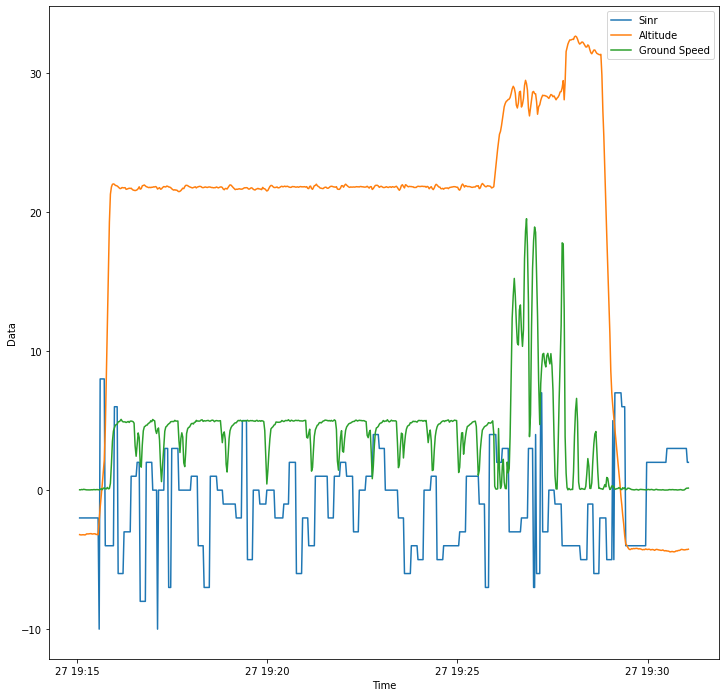

In [176]:
#Remove incomplete flights where there are missing data by check initial and final altitude with a 5 meter error margin due to air pressure change
complete_flights = []
for i in range(len(flights)):
    data = DataFrame (flights[i])
    rth = abs(data.iloc[0,17] - data.iloc[-1,17])
    if rth<5:
        complete_flights.append(data)
    
#Print complete flight
for i in range(len(complete_flights)):
    print("Flight N°", i+1, "has ", len(complete_flights[i]), " rows of data")
    
#Print complete flight data plots
for f in range(len(complete_flights)):
    #define figures for plots
    fig = plt.figure(figsize = (12, 12)).add_subplot()
    DF = DataFrame (complete_flights[f])

    #fig.plot(flights[f]['timestamp'], flights[f]['net_param.rssi'])
    fig.plot(DF['timestamp'], DF['net_param.sinr'])
    fig.plot(DF['timestamp'], DF['gps_param.altitude'])
    #fig.plot(LTE_DATA['timestamp'], LTE_DATA['net_param.rsrp'])
    #fig.plot(LTE_DATA['timestamp'], LTE_DATA['net_param.rsrq'])
    fig.plot(DF['timestamp'], DF['gps_param.groundspeed'])

    #add X, and Y labels
    fig.set_xlabel('Time')
    fig.set_ylabel('Data')
    fig.legend(['Sinr','Altitude','Ground Speed'])
    
    plot = px.scatter_mapbox(DF, lat='gps_param.latitude', lon='gps_param.longitude', color='net_param.sinr', size='gps_param.longitude', zoom=16,
                        mapbox_style="open-street-map")
    plot.show()


In [184]:
LTE_RSSI_HM = px.density_mapbox(LTE_DATA, lat='gps_param.latitude', lon='gps_param.longitude', z='net_param.rssi', zoom=12,
                        mapbox_style="open-street-map")

LTE_RSSI_HM.show()

#dp.Report(dp.Plot(LTE_RSSI_HM)).publish(name='LTE_RSSI_HeatMap_Ponteterra', open=True)

Text(0, 0.5, 'Data')

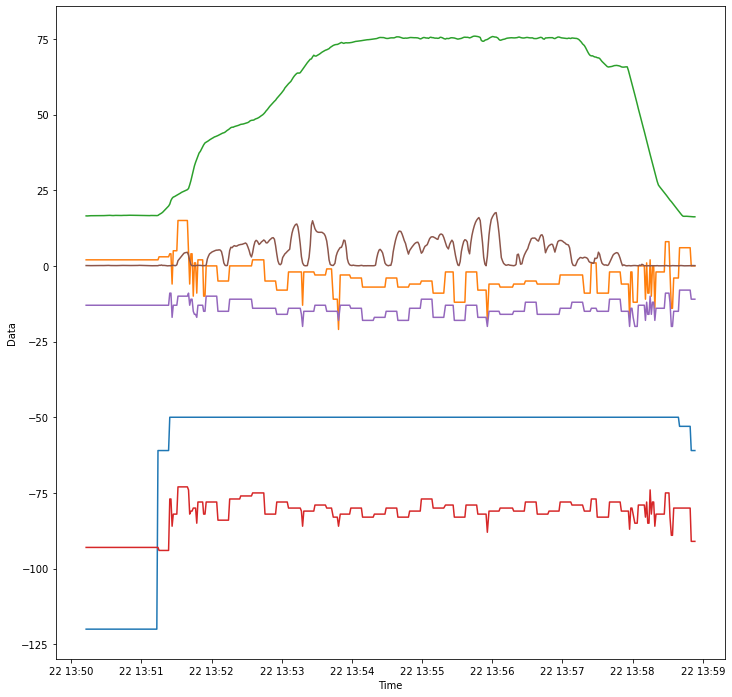

In [178]:
#define figures for plots
fig = plt.figure(figsize = (12, 12)).add_subplot()

fig.plot(LTE_DATA['timestamp'].head(510), LTE_DATA['net_param.rssi'].head(510))
fig.plot(LTE_DATA['timestamp'].head(510), LTE_DATA['net_param.sinr'].head(510))
fig.plot(LTE_DATA['timestamp'].head(510), LTE_DATA['gps_param.altitude'].head(510))
fig.plot(LTE_DATA['timestamp'].head(510), LTE_DATA['net_param.rsrp'].head(510))
fig.plot(LTE_DATA['timestamp'].head(510), LTE_DATA['net_param.rsrq'].head(510))
fig.plot(LTE_DATA['timestamp'].head(510), LTE_DATA['gps_param.groundspeed'].head(510),)

#add X, and Y labels
fig.set_xlabel('Time')
fig.set_ylabel('Data')

[[45.00752621 10.46380928]
 [44.99040582 10.45255975]
 [45.00564059 10.46173376]
 [45.00627937 10.45731644]]


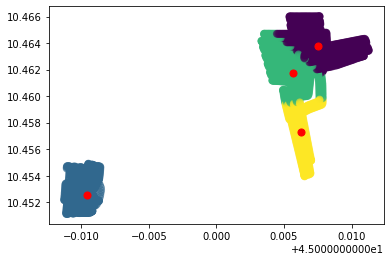

In [183]:
df = DataFrame(LTE_DATA,columns=['gps_param.latitude','gps_param.longitude'])

kmeans = KMeans(n_clusters=4).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df['gps_param.latitude'], df['gps_param.longitude'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [181]:
data = []
with open('LORAWAN.json') as f:
    for line in f:
        data.append(json.loads(line))
LORA_DATA = pd.json_normalize(data)
LORA_DATA



,timestamp,rssi,snr,latitude,longitude,altitude,hdop,satellites,speed,head,gateways
0,2021-05-22T08:54:00.593218415Z,-115.0,-4.0,44.990711,10.452648,15.179688,74,12,0.110657,326.0,NaN
1,2021-05-22T08:54:00.593218415Z,-115.0,-4.0,44.990711,10.452648,15.179688,74,12,0.110657,326.0,NaN
2,2021-05-22T08:54:08.216084588Z,-115.0,-3.0,44.990711,10.452651,15.250000,74,12,0.086792,326.0,NaN
3,2021-05-22T08:54:08.216084588Z,-115.0,-3.0,44.990711,10.452651,15.250000,74,12,0.086792,326.0,NaN
4,2021-05-22T08:54:15.684008168Z,-116.0,-4.0,44.990711,10.452651,15.382812,74,12,0.119385,326.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2612,2021-05-27T17:29:29.641225401Z,NaN,NaN,44.990715,10.452682,-4.191406,73,16,0.142944,121.0,"[{'gtw_id': 'eui-246f28ffff2224e8', 'timestamp..."
2613,2021-05-27T17:29:36.931083269Z,NaN,NaN,44.990711,10.452689,-4.199219,71,17,0.029587,119.0,"[{'gtw_id': 'eui-246f28ffff2224e8', 'timestamp..."
2614,2021-05-27T17:29:44.668938451Z,NaN,NaN,44.990711,10.452687,-4.210938,71,17,0.028305,118.0,"[{'gtw_id': 'eui-246f28ffff2224e8', 'timestamp..."
2615,2021-05-27T17:29:51.484145346Z,NaN,NaN,44.990711,10.452690,-4.281250,71,17,0.041138,116.0,"[{'gtw_id': 'eui-246f28ffff2224e8', 'timestamp..."
